In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [23]:
print(os.listdir('../input/data'))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [24]:
data = pd.read_csv('../input/data/Data_Entry_2017.csv', delimiter=',')

In [25]:
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [26]:
labels = data['Finding Labels'].str.split('|')

In [27]:
label_counts = labels.explode().value_counts()

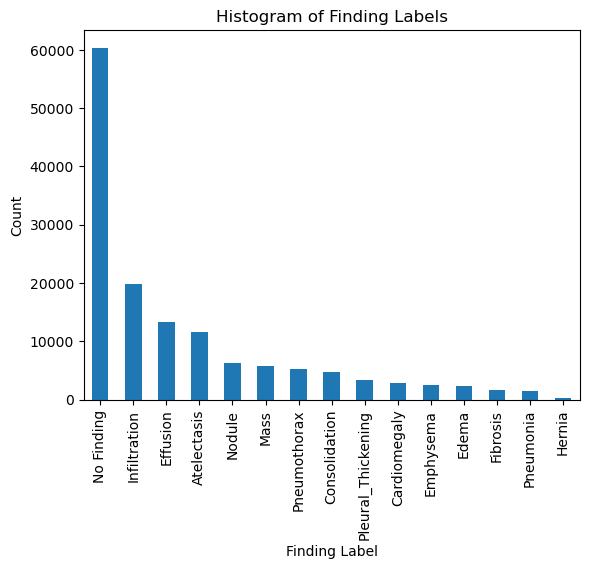

In [28]:
label_counts.plot(kind='bar')
plt.xlabel('Finding Label')
plt.ylabel('Count')
plt.title('Histogram of Finding Labels')
plt.show()

In [29]:
data = data[['Image Index', 'Finding Labels']]

In [30]:
data.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [31]:
sampled_dfs = []

In [32]:
image_numbers = 1000

In [33]:
for label, group in data.groupby('Finding Labels'):
    if label == 'No Finding':
        sampled_group = group.sample(n=min(len(group), 4*image_numbers))
    else:
        sampled_group = group.sample(n=min(len(group), image_numbers))
    sampled_dfs.append(sampled_group)

In [34]:
sampled_df = pd.concat(sampled_dfs)

In [35]:
sampled_df.head()

,Image Index,Finding Labels
100671,00026725_001.png,Atelectasis
81666,00020085_001.png,Atelectasis
71190,00017546_015.png,Atelectasis
40050,00010458_006.png,Atelectasis
7892,00002064_005.png,Atelectasis


In [36]:
label_counts = sampled_df['Finding Labels'].value_counts()

In [37]:
print(label_counts)

No Finding                                                  4000
Atelectasis                                                 1000
Cardiomegaly                                                1000
Effusion                                                    1000
Atelectasis|Effusion                                        1000
                                                            ... 
Atelectasis|Edema|Pneumonia                                    1
Edema|Effusion|Pleural_Thickening|Pneumonia|Pneumothorax       1
Edema|Effusion|Pleural_Thickening|Pneumonia                    1
Edema|Effusion|Pleural_Thickening                              1
Edema|Nodule|Pneumothorax                                      1
Name: Finding Labels, Length: 836, dtype: int64


In [18]:
base_path = '/kaggle/input/data'

In [19]:
for index, row in sampled_df.iterrows():
    image_filename = row['Image Index']
    
    for i in range(1, 13):
        folder_name = f'images_{i:03}'
        image_path = os.path.join(base_path, folder_name, 'images', image_filename)
        
        if os.path.isfile(image_path):
            sampled_df.loc[index, 'Image Path'] = image_path
            break

In [20]:
sampled_df.head()

,Image Index,Finding Labels,Image Path
294,00000066_000.png,Atelectasis,/kaggle/input/data/images_001/images/00000066_...
57037,00014172_004.png,Atelectasis,/kaggle/input/data/images_007/images/00014172_...
13199,00003428_001.png,Atelectasis,/kaggle/input/data/images_002/images/00003428_...
45457,00011654_006.png,Atelectasis,/kaggle/input/data/images_006/images/00011654_...
81893,00020147_009.png,Atelectasis,/kaggle/input/data/images_009/images/00020147_...


In [21]:
from fastai.vision.all import *

In [22]:
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('Image Path'),
    get_y=ColReader('Finding Labels', label_delim='|'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(460, method='squish'),
    batch_tfms=[*aug_transforms(size=224, max_warp=0)]
).dataloaders(sampled_df)

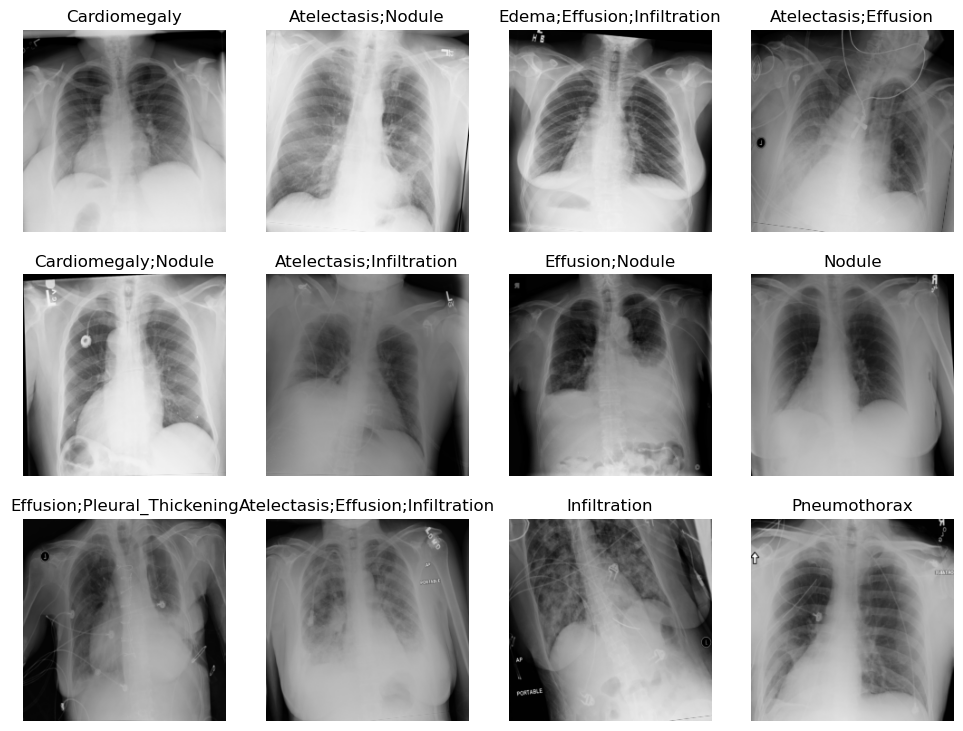

In [23]:
dls.show_batch(max_n=12)

In [24]:
from fastai import *

In [25]:
loss_func = nn.BCEWithLogitsLoss()

In [26]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2), loss_func=loss_func)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

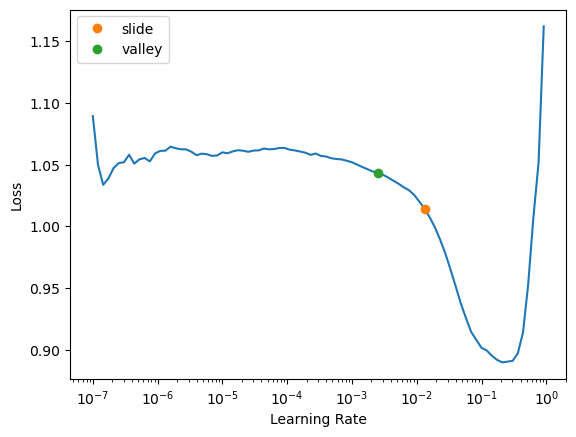

In [27]:
lr = learn.lr_find(suggest_funcs=(slide, valley))

In [28]:
base_lr = (lr.slide + lr.valley)/2
base_lr

0.007847226923331618

In [29]:
learn = learn.to_fp16()

In [30]:
learn.fine_tune(epochs=5, freeze_epochs=5, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.389161,0.332711,0.873919,0.061603,14:28
1,0.332027,0.318891,0.874888,0.102211,13:52
2,0.311395,0.301719,0.880462,0.120156,13:48
3,0.299242,0.297036,0.881317,0.183577,13:41
4,0.296171,0.293938,0.882759,0.172861,13:37
5,0.289184,0.287032,0.885551,0.217730,13:36
6,0.285955,0.285042,0.886046,0.246791,13:15
7,0.285198,0.281516,0.887169,0.240564,13:13
8,0.279425,0.282434,0.886138,0.249814,13:13
9,0.275628,0.278851,0.887200,0.269522,13:16


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


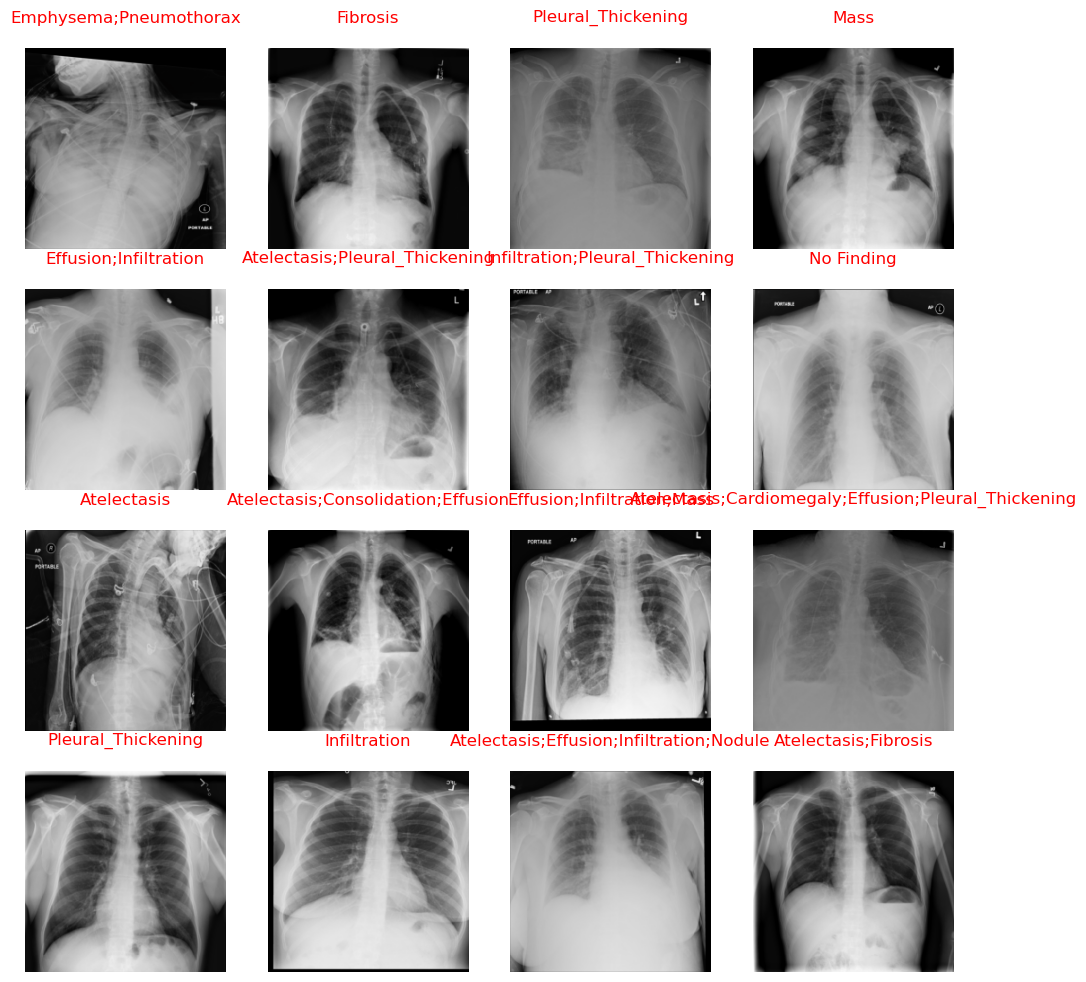

In [34]:
learn.show_results(max_n=16)

In [35]:
learn.export('model_v2.pkl')